In [40]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

In [93]:
n = 5
T = 0.01

In [94]:
def int_to_bin(i, n=None):
    'Convert a given integer to a bitstring of fixed length'
    if n is not None:
        return bin(i)[2:].zfill(n)
    else: return bin(i)[2:]
    
def bin_to_int(s):
    'Convert a given bitstring to integer'
    return int(s,2)

def random_bitstring(n):
    i = np.random.randint(0,2**n)
    return int_to_bin(i, n)

In [132]:
def E(s):
    'Simple energy function'
    if type(s) == type('s'): i = bin_to_int(s)
    else: i = s
    return np.exp(-(i-16)**2/16)

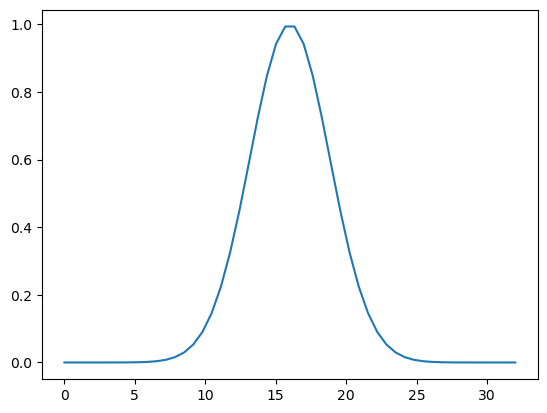

In [134]:
plt.plot(np.linspace(0,32), [E(s) for s in np.linspace(0,32)])

In [136]:
def propose_random():
    return random_bitstring(n)

def accept(s,s_new):
    A = min(1, np.exp(E(s)-E(s_new)/T))
    if A >= np.random.uniform(0,1): return True
    else: return False

In [149]:
samples = []

for i in range(1000):
    s = random_bitstring(n)
    for iter in range(1):
        s_new = propose_random()
        if accept(s, s_new): s = s_new
    samples.append(s)

In [150]:
integer_samples = [bin_to_int(s) for s in samples]

(array([207., 135.,  84.,  50.,  47.,  48.,  47.,  68., 117., 197.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

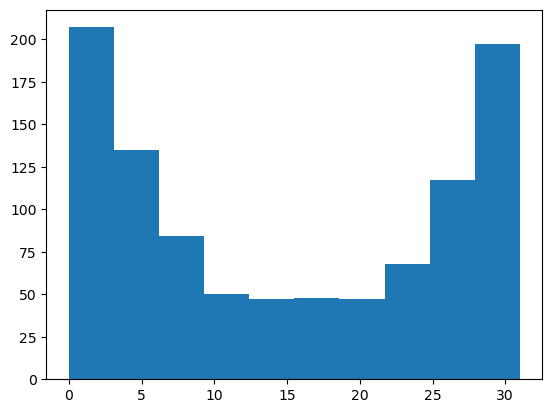

In [151]:
plt.hist(integer_samples)